In [2]:
# Univariate Time Series Regression using Transformers on Bitcoin Close Price Data
# Short term close bitcoin price prediction using Transformers 

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from tensorflow.keras import losses
from tensorflow.keras.constraints import MaxNorm as maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
#sound_file = 'beep.wav'
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import PowerTransformer

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os
from matplotlib import pyplot

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [5]:
# Time 2 Vec Custom Layer for Tensorflow 2

class Time2Vec(Layer):
    
    def __init__(self, dim=None, **kwargs):
        self.dim = dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.Wei = self.add_weight(name='Wei',
                                shape=(input_shape[-1], self.dim),
                                initializer='uniform',
                                trainable=True)

        self.Para = self.add_weight(name='Para',
                                shape=(input_shape[1], self.dim),
                                initializer='uniform',
                                trainable=True)

        self.wei = self.add_weight(name='wei',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.para = self.add_weight(name='para',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        initial = self.wei * x + self.para
        sine_transformation = K.sin(K.dot(x, self.Wei) + self.Para)
        
        return K.concatenate([sine_transformation, initial], -1)


In [6]:
# Dataset - FREE HISTORICAL DATA from https://www.cryptodatadownload.com/data/

# Data is organized by exchange and symbol. Please select the exchange grouping below. This data is offered for free under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License

dataframe = pd.read_csv("../data/new/gemini_BTCUSD_1hr.csv", sep=',', skiprows=1, 
                        parse_dates=True, squeeze=True, header=0, index_col=1)


In [7]:
dataframe.head(3)

Unix Timestamp  Symbol      Open      High       Low  \
Date                                                                        
2021-08-17 00:00:00   1629158400000  BTCUSD  45911.98  46092.77  45855.18   
2021-08-16 23:00:00   1629154800000  BTCUSD  46122.00  46200.48  45729.02   
2021-08-16 22:00:00   1629151200000  BTCUSD  46072.69  46352.96  46006.06   

                        Close     Volume  
Date                                      
2021-08-17 00:00:00  45869.40   8.181504  
2021-08-16 23:00:00  45911.98  64.325364  
2021-08-16 22:00:00  46122.00  45.393337

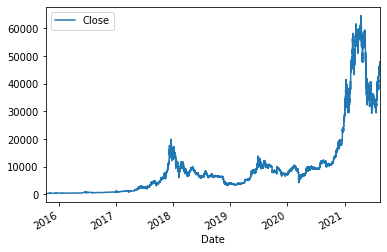

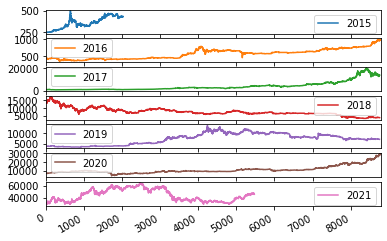

In [7]:
# Data Visualization
import warnings
warnings.filterwarnings('ignore')

# Price Data variation by year
series = dataframe[['Close']]
series.plot()
pyplot.show()

# Price Data variation by hours in a year 24*365=8760
years_ls = []
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    series_temp = pd.DataFrame()
    series_temp[name.year] = group.values.ravel()
    years_ls.append(name.year)
    years = pd.concat([years,series_temp], ignore_index=True, axis=1)
years.columns = years_ls
years.plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


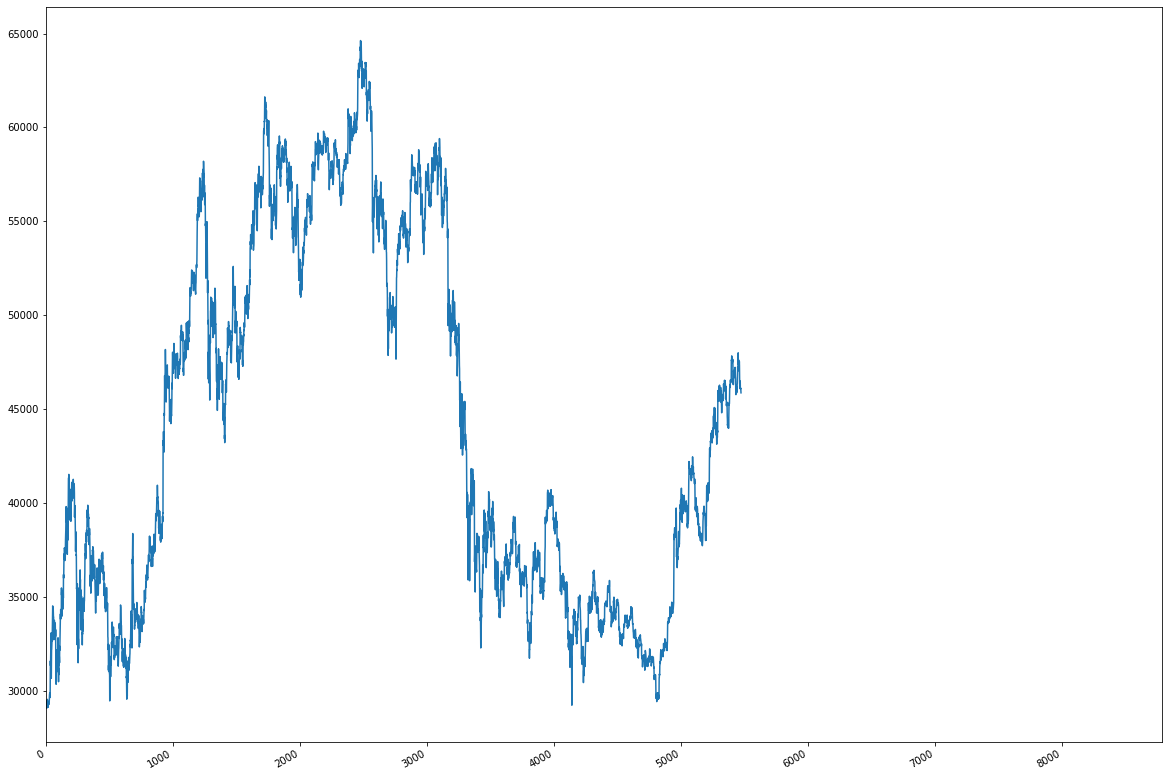

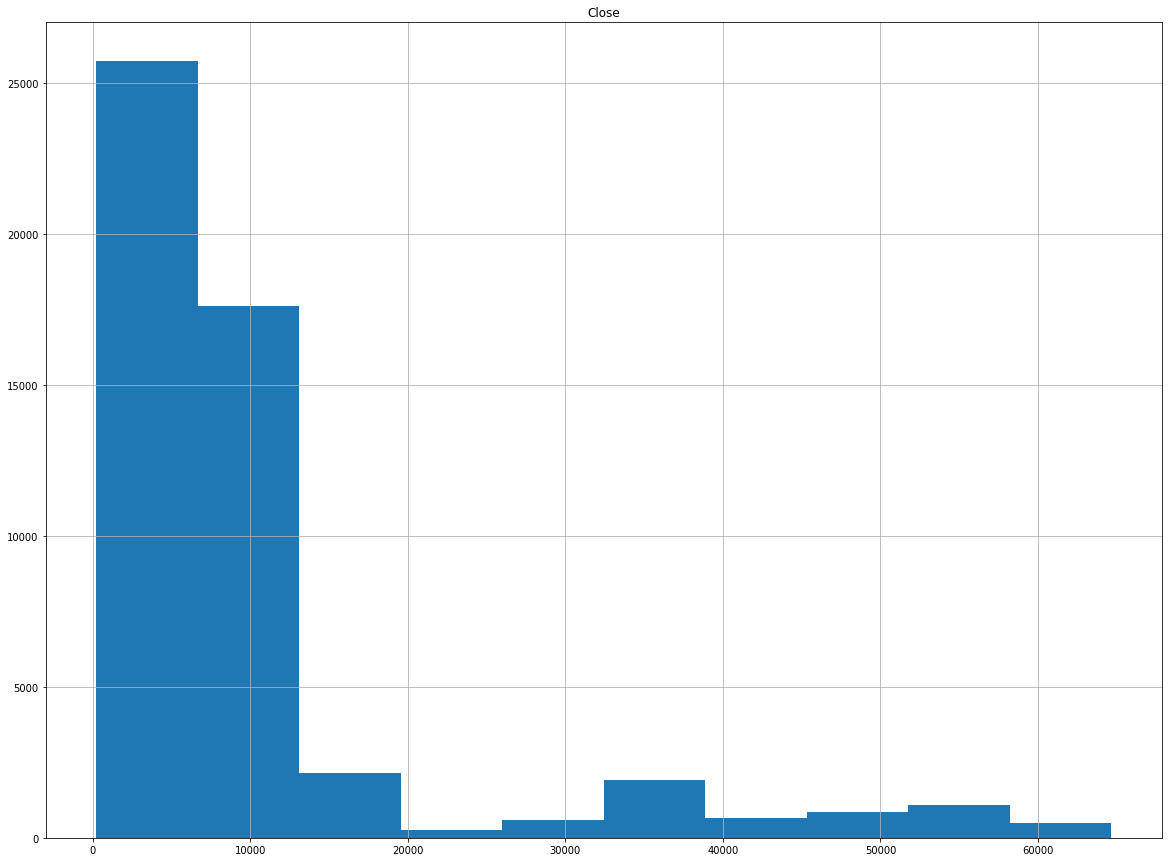

In [8]:
# 2021 Changes
years[2021].plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()


# Histogram of price distribution - as we can see looks highly skewed
series.hist()
pyplot.show()

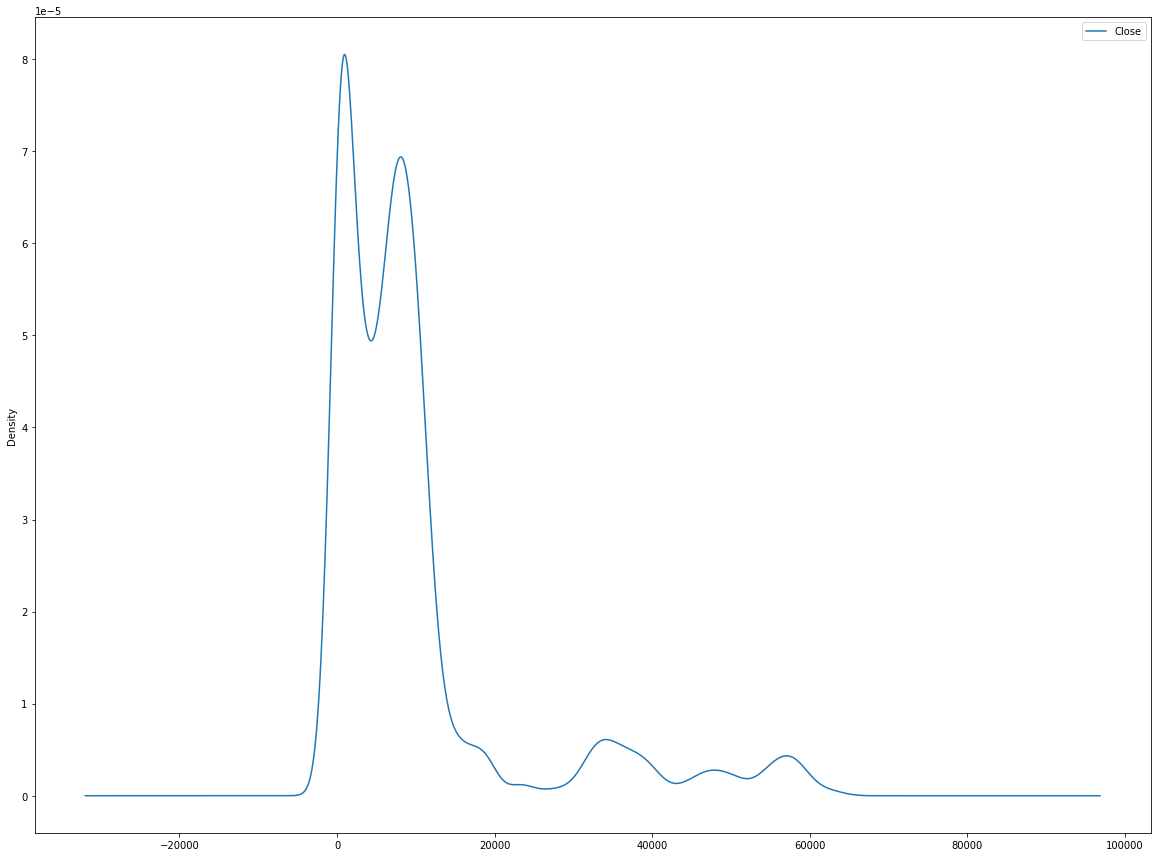

In [9]:
# Density Plot to see the distribution
series.plot(kind='kde')
pyplot.show()

In [10]:
# Scaling using Power transform and spliting the dataset
dataframe = pd.read_csv("../data/new/gemini_BTCUSD_1hr.csv", sep=',', skiprows=1, 
                        parse_dates=True, squeeze=True, header=0, index_col=1)
dataframe
#dataset = dataframe#[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2017-01-01 00:00:00')]

Unix Timestamp  Symbol      Open      High       Low  \
Date                                                                        
2021-08-17 00:00:00   1629158400000  BTCUSD  45911.98  46092.77  45855.18   
2021-08-16 23:00:00   1629154800000  BTCUSD  46122.00  46200.48  45729.02   
2021-08-16 22:00:00   1629151200000  BTCUSD  46072.69  46352.96  46006.06   
2021-08-16 21:00:00   1629147600000  BTCUSD  46069.96  46249.99  45903.58   
2021-08-16 20:00:00   1629144000000  BTCUSD  46087.02  46128.05  45661.78   
...                             ...     ...       ...       ...       ...   
2015-10-08 17:00:00      1444323600  BTCUSD    244.25    244.99    244.02   
2015-10-08 16:00:00      1444320000  BTCUSD    244.92    244.92    244.25   
2015-10-08 15:00:00      1444316400  BTCUSD    245.00    245.00    244.92   
2015-10-08 14:00:00      1444312800  BTCUSD    245.00    245.00    244.50   
2015-10-08 13:00:00      1444309200  BTCUSD      0.00    245.00      0.00   

                        Close      Volume  
Date                                       
2021-08-17 00:00:00  45869.40    8.181504  
2021-08-16 23:00:00  45911.98   64.325364  
2021-08-16 22:00:00  46122.00   45.393337  
2021-08-16 21:00:00  46072.69   42.772270  
2021-08-16 20:00:00  46069.96  118.073849  
...                       ...         ...  
2015-10-08 17:00:00    244.99    3.920632  
2015-10-08 16:00:00    244.25    3.895252  
2015-10-08 15:00:00    244.92    3.016926  
2015-10-08 14:00:00    245.00    4.453649  
2015-10-08 13:00:00    245.00    0.606654  

[51345 rows x 7 columns]

In [11]:
# Preprocessing Steps

dataset = dataframe#[pd.to_datetime(dataframe['Date']) > pd.to_datetime('2017-01-01 00:00:00')]

# As we can see in the density plots, the data is high skewed, 
# so we are going to do a median based replacement on IOR quantitle score 
# for values of std deviation less than 25% and more than 75% 

# length=dataset.shape[1]

# for i in dataset.columns:
#     try:
#         dataset[i] = np.where(dataset[i] > dataframe[i].quantile(0.75), dataframe[i].quantile(0.50), dataframe[i])
#         #dataset[i] = np.where(dataset[i] < dataframe[i].quantile(0.25), dataframe[i].quantile(0.50), dataframe[i])
#     except:
#         pass

# Transform
dataset = dataset[['Close']].values.astype('float32')
pw_transform = PowerTransformer()
dataset = pw_transform.fit_transform(dataset)

# Spliting the dataset
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# Creating dataset with timesteps
def create_dataset_with_timesteps(dataset, timesteps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timesteps-1):
        a = dataset[i:(i+timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])

    return np.array(dataX), np.array(dataY)

# Creating dataset for 10 timesteps
timesteps = 10
X_train, y_train = create_dataset_with_timesteps(train, timesteps)
X_test, y_test = create_dataset_with_timesteps(test, timesteps)

# Removing Outliers

# #A lot of local outliers due to variance over time will affect convergence removing 
# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]

# reshape input to be [samples, time steps, features] for time2vec
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

41076 10269


In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [13]:
# Model Arch - Time2VEC-LSTM-Dense, Loss: MAE, Opt: Adam
model = Sequential()
model.add(Time2Vec(4))
model.add(LSTM(4, input_shape=(1, timesteps), dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_split=0.1)
model.evaluate(X_test, y_test, batch_size=32)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 36958 samples, validate on 4107 samples
Epoch 1/200
36958/36958 - 17s - loss: 0.1615 - val_loss: 0.5390
Epoch 2/200
36958/36958 - 16s - loss: 0.0910 - val_loss: 0.3782
Epoch 3/200
36958/36958 - 16s - loss: 0.0676 - val_loss: 0.2064
Epoch 4/200
36958/36958 - 17s - loss: 0.0498 - val_loss: 0.1740
Epoch 5/200
36958/36958 - 17s - loss: 0.0390 - val_loss: 0.1627
Epoch 6/200
36958/36958 - 18s - loss: 0.0335 - val_loss: 0.1581
Epoch 7/200
36958/36958 - 18s - loss: 0.0305 - val_loss: 0.1573
Epoch 8/200
36958/36958 - 18s - loss: 0.0285 - val_loss: 0.1490
Epoch 9/200
36958/36958 - 19s - loss: 0.0288 - val_loss: 0.1379
Epoch 10/200
36958/36958 - 18s - loss: 0.0274 - val_loss: 0.1484
Epoch 11/200
3695

Epoch 116/200
36958/36958 - 18s - loss: 0.0213 - val_loss: 0.0361
Epoch 117/200
36958/36958 - 20s - loss: 0.0211 - val_loss: 0.0328
Epoch 118/200
36958/36958 - 18s - loss: 0.0206 - val_loss: 0.0327
Epoch 119/200
36958/36958 - 20s - loss: 0.0213 - val_loss: 0.0315
Epoch 120/200
36958/36958 - 20s - loss: 0.0209 - val_loss: 0.0338
Epoch 121/200
36958/36958 - 20s - loss: 0.0210 - val_loss: 0.0399
Epoch 122/200
36958/36958 - 19s - loss: 0.0205 - val_loss: 0.0291
Epoch 123/200
36958/36958 - 18s - loss: 0.0210 - val_loss: 0.0339
Epoch 124/200
36958/36958 - 19s - loss: 0.0212 - val_loss: 0.0278
Epoch 125/200
36958/36958 - 19s - loss: 0.0210 - val_loss: 0.0427
Epoch 126/200
36958/36958 - 20s - loss: 0.0208 - val_loss: 0.0289
Epoch 127/200
36958/36958 - 18s - loss: 0.0212 - val_loss: 0.0241
Epoch 128/200
36958/36958 - 19s - loss: 0.0213 - val_loss: 0.0486
Epoch 129/200
36958/36958 - 20s - loss: 0.0207 - val_loss: 0.0382
Epoch 130/200
36958/36958 - 19s - loss: 0.0204 - val_loss: 0.0409
Epoch 131/

0.05012972569821243

In [14]:
import math

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


trainPredict = pw_transform.inverse_transform(trainPredict)
y_train = pw_transform.inverse_transform(y_train.reshape(-1, 1))
testPredict = pw_transform.inverse_transform(testPredict)
y_test = pw_transform.inverse_transform(y_test.reshape(-1, 1))

#trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(y_test, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))

mae=mean_absolute_error(y_test, testPredict) #mae

r2=r2_score(y_test, testPredict) #testing score/ r^2
print('Test Score: MAE: {} R^2: {}'.format(mae, r2))

Test Score: MAE: 40.55460739135742 R^2: 0.8776922290759419


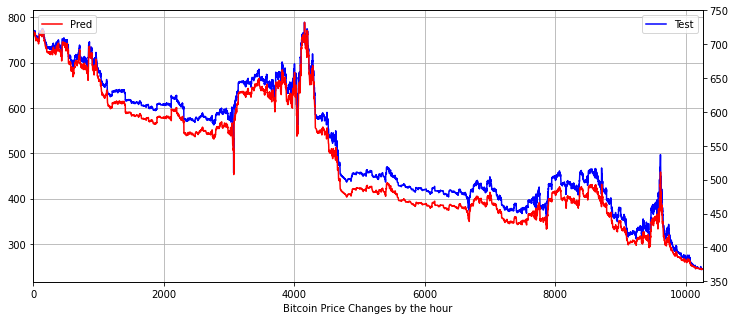

In [16]:

df_test = pd.DataFrame(columns=["Test", "Pred"])
df_test["Test"] = y_test.ravel()
df_test["Pred"] = testPredict.ravel()

plt.figure(figsize=(12,5))
plt.xlabel('Bitcoin Price Changes by the hour')

ax1 = df_test.Test.plot(color='blue', grid=True, label='Test')
ax2 = df_test.Pred.plot(color='red', grid=True, secondary_y=True, label='Pred')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

In [17]:
# mae=mean_absolute_error(y_test, testPredict) #mae

# r2=r2_score(y_test, testPredict) #testing score/ r^2
# print('Test Score: MAE: {} R^2: {}'.format(mae, r2))

math.sqrt(mean_squared_error(y_test, testPredict))

47.44324322941044

In [46]:
# Analysis of Data from 2019 to 2021
dataset_2019_2021 = dataframe[pd.to_datetime(dataframe['Unix Timestamp'], unit='ms', origin='unix') > pd.to_datetime('2019-01-01 00:00:00')]

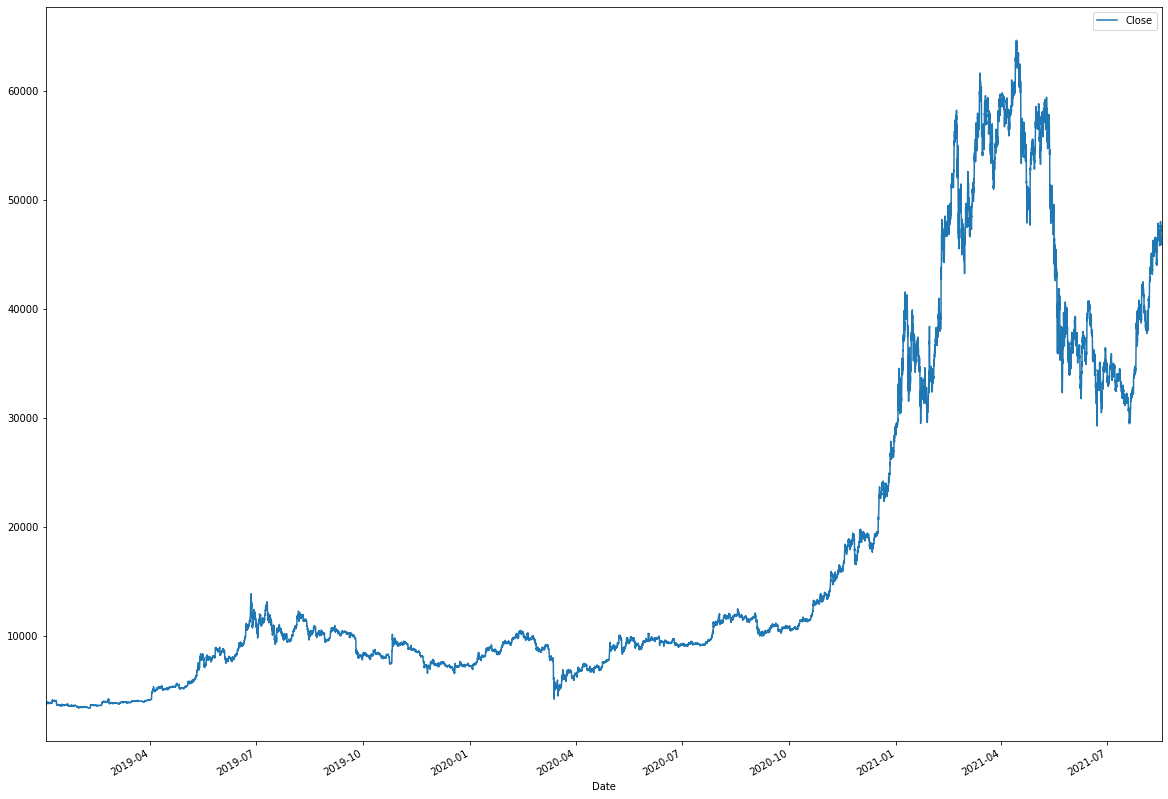

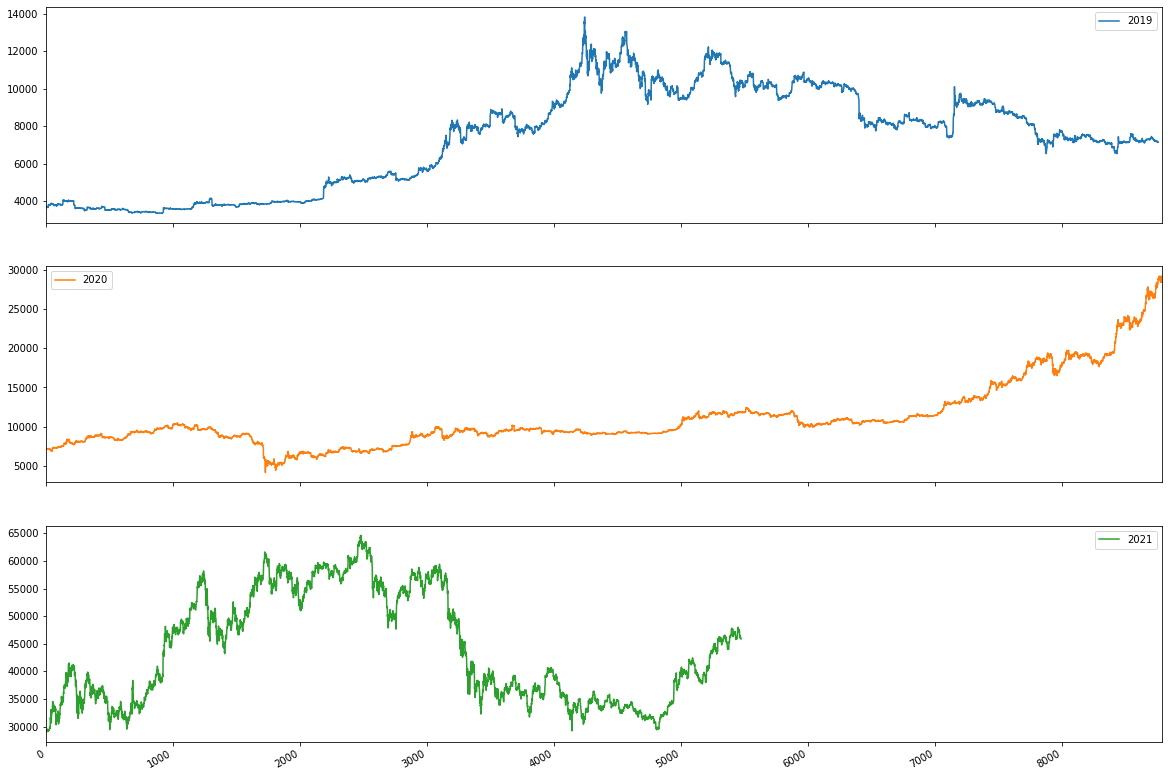

In [47]:
# Data Visualization
import warnings
warnings.filterwarnings('ignore')

# Price Data variation by year
series = dataset_2019_2021[['Close']]
series.plot()
pyplot.show()

# Price Data variation by hours in a year 24*365=8760
years_ls = []
groups = series.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    series_temp = pd.DataFrame()
    series_temp[name.year] = group.values.ravel()
    years_ls.append(name.year)
    years = pd.concat([years,series_temp], ignore_index=True, axis=1)
years.columns = years_ls
years.plot(subplots=True)
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()

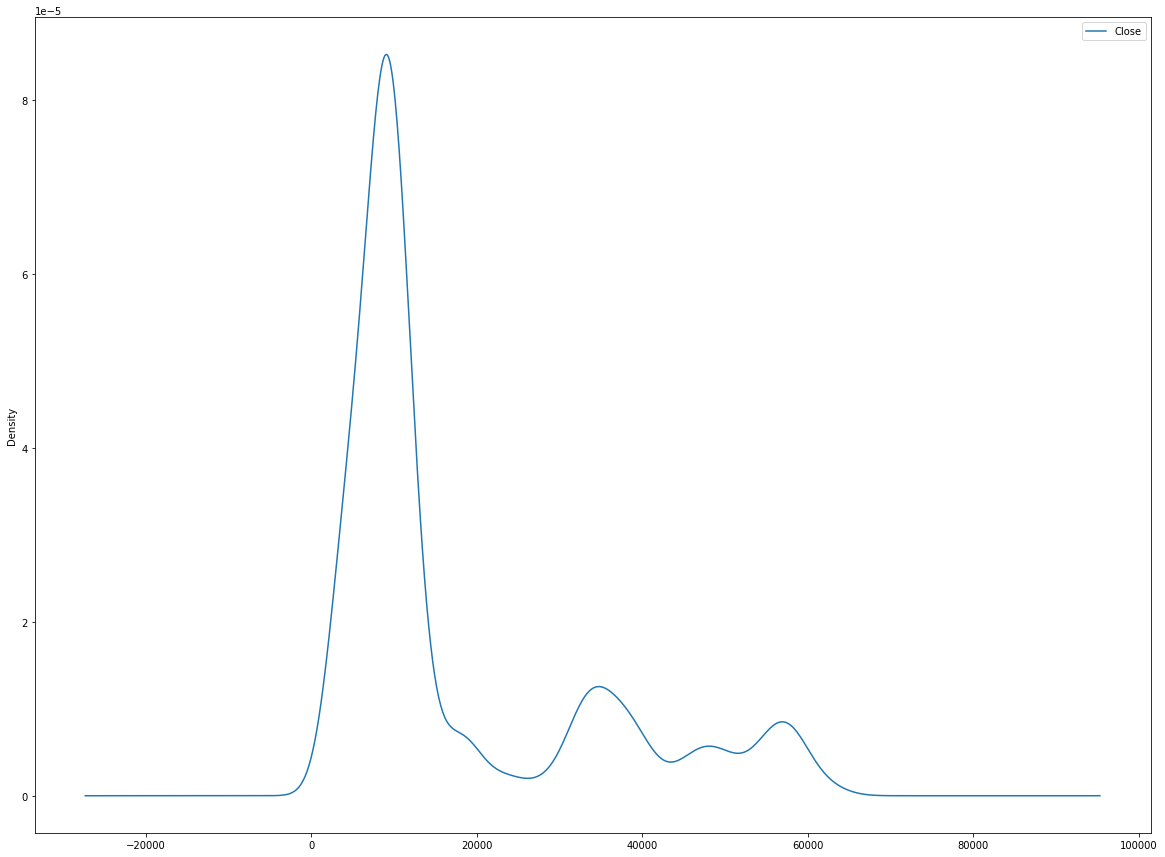

In [10]:


# Density Plot to see the distribution
series.plot(kind='kde')
pyplot.show()

In [48]:

# Transform
dataset_2019_2021 = dataset_2019_2021[['Close']].values.astype('float32')
#pw_transform = PowerTransformer()
scaler = MinMaxScaler(feature_range=(0, 1))
#dataset = scaler.fit_transform(dataset)
dataset_2019_2021 = scaler.fit_transform(dataset_2019_2021)

# Spliting the dataset
train_size = int(len(dataset_2019_2021) * 0.80)
test_size = len(dataset_2019_2021) - train_size
train, test = dataset_2019_2021[0:train_size, :], dataset_2019_2021[train_size:len(dataset_2019_2021), :]
print(len(train), len(test))

# Creating dataset with timesteps
def create_dataset_with_timesteps(dataset, timesteps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-timesteps-1):
        a = dataset[i:(i+timesteps), 0]
        dataX.append(a)
        dataY.append(dataset[i + timesteps, 0])

    return np.array(dataX), np.array(dataY)

# Creating dataset for 10 timesteps
timesteps = 10
X_train, y_train = create_dataset_with_timesteps(train, timesteps)
X_test, y_test = create_dataset_with_timesteps(test, timesteps)

# Removing Outliers

# #A lot of local outliers due to variance over time will affect convergence removing 
# from sklearn.neighbors import LocalOutlierFactor

# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train)
# mask = yhat != -1
# X_train, y_train = X_train[mask, :], y_train[mask]

# reshape input to be [samples, time steps, features] for time2vec
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

18410 4603


In [49]:
# Model Arch - Time2VEC-LSTM-Dense, Loss: MAE, Opt: Adam
model = Sequential()
model.add(Time2Vec(4))
model.add(LSTM(4, input_shape=(1, timesteps)))
model.add(Dense(1))
#model.add(Dropout(0.5))
model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_split=0.1)
model.evaluate(X_test, y_test, batch_size=32)

Train on 16559 samples, validate on 1840 samples
Epoch 1/200
16559/16559 - 9s - loss: 0.0500 - val_loss: 0.0017
Epoch 2/200
16559/16559 - 7s - loss: 0.0058 - val_loss: 0.0036
Epoch 3/200
16559/16559 - 6s - loss: 0.0053 - val_loss: 0.0052
Epoch 4/200
16559/16559 - 8s - loss: 0.0048 - val_loss: 0.0016
Epoch 5/200
16559/16559 - 8s - loss: 0.0046 - val_loss: 0.0033
Epoch 6/200
16559/16559 - 5s - loss: 0.0041 - val_loss: 0.0028
Epoch 7/200
16559/16559 - 5s - loss: 0.0041 - val_loss: 0.0014
Epoch 8/200
16559/16559 - 6s - loss: 0.0038 - val_loss: 0.0019
Epoch 9/200
16559/16559 - 8s - loss: 0.0036 - val_loss: 0.0012
Epoch 10/200
16559/16559 - 8s - loss: 0.0035 - val_loss: 0.0048
Epoch 11/200
16559/16559 - 7s - loss: 0.0035 - val_loss: 0.0019
Epoch 12/200
16559/16559 - 5s - loss: 0.0033 - val_loss: 0.0011
Epoch 13/200
16559/16559 - 5s - loss: 0.0032 - val_loss: 0.0011
Epoch 14/200
16559/16559 - 7s - loss: 0.0032 - val_loss: 0.0024
Epoch 15/200
16559/16559 - 5s - loss: 0.0033 - val_loss: 0.0025


Epoch 125/200
16559/16559 - 7s - loss: 0.0024 - val_loss: 0.0012
Epoch 126/200
16559/16559 - 8s - loss: 0.0024 - val_loss: 0.0012
Epoch 127/200
16559/16559 - 8s - loss: 0.0023 - val_loss: 8.0946e-04
Epoch 128/200
16559/16559 - 8s - loss: 0.0025 - val_loss: 0.0011
Epoch 129/200
16559/16559 - 6s - loss: 0.0024 - val_loss: 0.0011
Epoch 130/200
16559/16559 - 8s - loss: 0.0024 - val_loss: 0.0010
Epoch 131/200
16559/16559 - 8s - loss: 0.0025 - val_loss: 9.9547e-04
Epoch 132/200
16559/16559 - 6s - loss: 0.0024 - val_loss: 8.2989e-04
Epoch 133/200
16559/16559 - 8s - loss: 0.0023 - val_loss: 0.0013
Epoch 134/200
16559/16559 - 8s - loss: 0.0024 - val_loss: 8.8018e-04
Epoch 135/200
16559/16559 - 8s - loss: 0.0024 - val_loss: 9.5798e-04
Epoch 136/200
16559/16559 - 7s - loss: 0.0024 - val_loss: 8.3846e-04
Epoch 137/200
16559/16559 - 6s - loss: 0.0023 - val_loss: 0.0015
Epoch 138/200
16559/16559 - 7s - loss: 0.0024 - val_loss: 8.1485e-04
Epoch 139/200
16559/16559 - 8s - loss: 0.0024 - val_loss: 9.37

0.0006103997541841393

In [50]:
import math

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

mae=mean_absolute_error(y_test, testPredict) #mae

r2=r2_score(y_test, testPredict) #testing score/ r^2
print('Test Score: MAE: {} R^2: {}'.format(mae, r2))

Train Score: 249.69 RMSE
Test Score: 69.42 RMSE
Test Score: MAE: 37.40195083618164 R^2: 0.9992892893636258


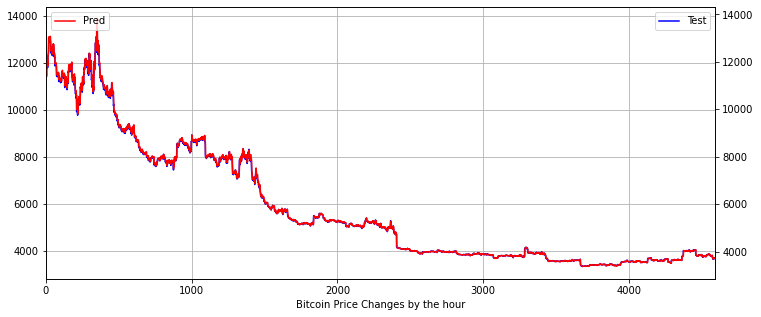

In [51]:

df_test = pd.DataFrame(columns=["Test", "Pred"])
df_test["Test"] = y_test.ravel()
df_test["Pred"] = testPredict.ravel()

plt.figure(figsize=(12,5))
plt.xlabel('Bitcoin Price Changes by the hour')

ax1 = df_test.Test.plot(color='blue', grid=True, label='Test')
ax2 = df_test.Pred.plot(color='red', grid=True, secondary_y=True, label='Pred')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()